In [4]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from PIL import Image
import torchvision.transforms as T
from torchvision.transforms.functional import InterpolationMode
from torch.optim.lr_scheduler import CosineAnnealingLR
import numpy as np
import matplotlib.pyplot as plt

# ----------------------
# Configuration
# ----------------------
CONFIG = {
    "labeled_img": "dataset/labeled_data/images",
    "labeled_mask": "dataset/labeled_data/labels", 
    "unlabeled_img": "dataset/unlabeled_data/images",
    "epochs": 50,
    "batch_size": 4,  # Reduce if memory issues
    "lr": 2e-4,
    "save_dir": "models",
    "num_workers": 2
}

# ----------------------
# Fixed Transforms
# ----------------------
class BatchCutMix:
    def __init__(self, alpha=1.0):
        self.alpha = alpha

    def __call__(self, batch):
        images, labels = batch
        lam = np.random.beta(self.alpha, self.alpha)
        rand_index = torch.randperm(images.size(0))
        
        # Generate random bounding box 
        H, W = images.size()[2:]
        cut_rat = np.sqrt(1. - lam)
        cut_w = int(W * cut_rat)
        cut_h = int(H * cut_rat)
        
        cx = np.random.randint(W)
        cy = np.random.randint(H)
        bbx1 = np.clip(cx - cut_w // 2, 0, W)
        bby1 = np.clip(cy - cut_h // 2, 0, H)
        bbx2 = np.clip(cx + cut_w // 2, 0, W)
        bby2 = np.clip(cy + cut_h // 2, 0, H)

        # Apply cutmix
        images[:, :, bbx1:bbx2, bby1:bby2] = images[rand_index, :, bbx1:bbx2, bby1:bby2]
        return images, labels

transform_labeled = T.Compose([
    T.Resize((256, 256)),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomVerticalFlip(p=0.5),
    T.RandomRotation(15),
    T.ColorJitter(0.2, 0.2, 0.2, 0.1),
    T.ToTensor(),
])

transform_unlabeled = T.Compose([
    T.Resize((256, 256)),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomVerticalFlip(p=0.5),
    T.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    T.ColorJitter(0.3, 0.3, 0.3, 0.2),
    T.GaussianBlur(3, sigma=(0.1, 2.0)),
    T.ToTensor(),
])

transform_mask = T.Compose([
    T.Resize((256, 256), interpolation=InterpolationMode.NEAREST),
    T.PILToTensor(),
    lambda x: x.squeeze(0).long()
])

# ----------------------
# Fixed Dataset Classes
# ----------------------
class CervicalDataset(Dataset):
    def __init__(self, img_dir, mask_dir=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.is_labeled = mask_dir is not None
        self.image_paths = sorted([os.path.join(img_dir, f) for f in os.listdir(img_dir) 
                              if f.endswith(('.png', '.jpg'))])
        if self.is_labeled:
            self.mask_paths = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir) 
                                 if f.endswith(('.png', '.jpg'))])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        if self.is_labeled:
            mask = Image.open(self.mask_paths[idx]).convert("L")
            return transform_labeled(image), transform_mask(mask)
        return transform_unlabeled(image)

# ----------------------
# Enhanced U-Net Model
# ----------------------
class AttentionBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, 1, kernel_size=1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        att = self.conv(x)
        return x * self.sigmoid(att)

class CervicalUNet(nn.Module):
    def __init__(self, in_channels=3, num_classes=3):
        super().__init__()
        
        # Encoder
        self.enc1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.pool1 = nn.MaxPool2d(2)
        
        self.enc2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.pool2 = nn.MaxPool2d(2)
        
        # Bottleneck with attention
        self.bottleneck = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.attention = AttentionBlock(256)
        self.feature_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Decoder
        self.up1 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec1 = nn.Sequential(
            nn.Conv2d(256, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        
        self.up2 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec2 = nn.Sequential(
            nn.Conv2d(128, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        
        self.seg_head = nn.Sequential(
            nn.Conv2d(64, num_classes, 1),
            nn.BatchNorm2d(num_classes),
            nn.ReLU(inplace=True)
        )

    def forward_features(self, x):
        e1 = self.enc1(x)
        p1 = self.pool1(e1)
        e2 = self.enc2(p1)
        p2 = self.pool2(e2)
        bn = self.bottleneck(p2)
        att = self.attention(bn)
        return self.feature_pool(att).squeeze(-1).squeeze(-1)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        p1 = self.pool1(e1)
        e2 = self.enc2(p1)
        p2 = self.pool2(e2)
        
        # Bottleneck
        bn = self.bottleneck(p2)
        bn = self.attention(bn)
        
        # Decoder
        d1 = self.up1(bn)
        d1 = torch.cat([d1, e2], dim=1)
        d1 = self.dec1(d1)
        
        d2 = self.up2(d1)
        d2 = torch.cat([d2, e1], dim=1)
        d2 = self.dec2(d2)
        
        return self.seg_head(d2)

# ----------------------
# Semi-Supervised Framework
# ----------------------
class SemiSupervisedModel(nn.Module):
    def __init__(self, num_classes=3, alpha=0.999):
        super().__init__()
        self.student = CervicalUNet(num_classes=num_classes)
        self.teacher = CervicalUNet(num_classes=num_classes)
        self.alpha = alpha
        self._init_teacher()
        
        # Loss parameters
        self.lambda_unsup = 0.1
        self.lambda_sat = 0.1
        self.conf_thresh = 0.65

    def _init_teacher(self):
        with torch.no_grad():
            for t_param, s_param in zip(self.teacher.parameters(), self.student.parameters()):
                t_param.data.copy_(s_param.data)

    @torch.no_grad()
    def update_teacher(self, global_step):
        alpha = min(1 - 1/(global_step/100 + 1), self.alpha)
        for t_param, s_param in zip(self.teacher.parameters(), self.student.parameters()):
            t_param.data.mul_(alpha).add_(s_param.data, alpha=1-alpha)

    def forward(self, x):
        return self.student(x)

# ----------------------
# Loss Functions
# ----------------------
def compute_sat_loss(student_feats, teacher_feats, temperature=0.1):
    student_feats = F.normalize(student_feats, p=2, dim=1)
    teacher_feats = F.normalize(teacher_feats, p=2, dim=1)
    
    sim_matrix = torch.mm(student_feats, teacher_feats.t()) / temperature
    pos_sim = torch.diag(sim_matrix)
    neg_sim = (sim_matrix.sum(dim=1) - pos_sim) / (sim_matrix.size(1) - 1)
    
    loss = -torch.log(torch.exp(pos_sim) / (torch.exp(pos_sim) + torch.exp(neg_sim) + 1e-8)).mean()
    return loss

class AdaptiveLoss(nn.Module):
    def __init__(self, class_weights=None):
        super().__init__()
        self.class_weights = class_weights
        
    def forward(self, preds, targets):
        # Cross-Entropy
        ce_loss = F.cross_entropy(preds, targets, weight=self.class_weights)
        
        # Dice Loss
        smooth = 1e-6
        preds_soft = F.softmax(preds, dim=1)
        targets_oh = F.one_hot(targets, num_classes=preds.shape[1]).permute(0,3,1,2).float()
        
        intersection = (preds_soft * targets_oh).sum(dim=(2,3))
        union = preds_soft.sum(dim=(2,3)) + targets_oh.sum(dim=(2,3))
        dice_loss = 1 - (2. * intersection + smooth) / (union + smooth)
        
        return ce_loss + dice_loss.mean()

# ----------------------
# Training Utilities
# ----------------------
def dice_score(pred, target):
    smooth = 1e-6
    pred = pred.argmax(1)
    return (2.0 * (pred * target).sum() + smooth) / (pred.sum() + target.sum() + smooth)

def jupyter_train():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    os.makedirs(CONFIG["save_dir"], exist_ok=True)
    
    # Datasets
    labeled_ds = CervicalDataset(CONFIG["labeled_img"], CONFIG["labeled_mask"])
    unlabeled_ds = CervicalDataset(CONFIG["unlabeled_img"])
    
    # Class weights
    class_counts = torch.zeros(3)
    for _, mask in labeled_ds:
        class_counts += torch.bincount(mask.flatten(), minlength=3)
    class_weights = (1.0 / (class_counts / class_counts.sum())).to(device)
    
    # Data loaders
    labeled_loader = DataLoader(
        labeled_ds, 
        batch_size=CONFIG["batch_size"], 
        shuffle=True,
        num_workers=CONFIG["num_workers"],
        pin_memory=True
    )
    
    unlabeled_loader = DataLoader(
        unlabeled_ds,
        batch_size=CONFIG["batch_size"]*2,
        shuffle=True,
        num_workers=CONFIG["num_workers"],
        pin_memory=True
    )
    
    # Initialize model and losses
    model = SemiSupervisedModel(num_classes=3).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=CONFIG["lr"], weight_decay=1e-4)
    scheduler = CosineAnnealingLR(optimizer, T_max=CONFIG["epochs"])
    
    # Initialize loss functions
    sup_criterion = AdaptiveLoss(class_weights=class_weights)
    unsup_criterion = AdaptiveLoss()

    # Initialize progress bars
    epoch_pbar = tqdm(total=CONFIG["epochs"], desc="Overall Progress", position=0)
    print("\n")
    print(f"{'epoch':<6} {'train_loss':<10} {'sup_loss':<10} {'unsup_loss':<10} {'sat_loss':<10} {'dice':<10}")
    print("-"*65)

    # Training loop
    for epoch in range(CONFIG["epochs"]):
        model.train()
        total_loss = 0.0
        sup_loss_total = 0.0
        unsup_loss_total = 0.0
        sat_loss_total = 0.0
        dice_total = 0.0
        batch_count = 0
        
        # Dynamic parameters
        current_thresh = 0.65 + min(epoch/CONFIG["epochs"], 1)*0.25
        current_lambda_unsup = min(epoch/10 * 0.5, 0.5)
        current_lambda_sat = 0.2 * (1 - epoch/CONFIG["epochs"])

        # Batch progress bar
        batch_pbar = tqdm(total=len(labeled_loader), 
                        leave=False, 
                        position=1,
                        desc=f"Epoch {epoch+1} batches")
        
        for (labeled_x, labeled_y), unlabeled_x in zip(labeled_loader, unlabeled_loader):
            # Move data to device
            labeled_x, labeled_y = labeled_x.to(device), labeled_y.to(device)
            unlabeled_x = unlabeled_x.to(device)
            
            # Forward passes
            student_preds = model(labeled_x)
            sup_loss = sup_criterion(student_preds, labeled_y)
            
            # Unsupervised loss
            with torch.no_grad():
                teacher_preds = model.teacher(unlabeled_x)
                pseudo_probs = F.softmax(teacher_preds, dim=1)
                max_probs, pseudo_labels = torch.max(pseudo_probs, dim=1)
                mask = (max_probs > current_thresh).float()
            
            unsup_loss = torch.tensor(0.0, device=device)
            if mask.sum() > 0:
                student_u_preds = model(unlabeled_x)
                unsup_loss = unsup_criterion(student_u_preds, pseudo_labels) * mask.mean()
            
            # Feature alignment loss
            with torch.no_grad():
                t_features = model.teacher.forward_features(unlabeled_x)
            s_features = model.student.forward_features(unlabeled_x)
            sat_loss = compute_sat_loss(s_features, t_features)
            
            # Total loss
            total_batch_loss = sup_loss + current_lambda_unsup*unsup_loss + current_lambda_sat*sat_loss
            
            # Backpropagation
            optimizer.zero_grad()
            total_batch_loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            
            # Calculate metrics
            with torch.no_grad():
                dice = dice_score(student_preds, labeled_y)
            
            # Accumulate metrics
            total_loss += total_batch_loss.item()
            sup_loss_total += sup_loss.item()
            unsup_loss_total += unsup_loss.item() if unsup_loss != 0 else 0
            sat_loss_total += sat_loss.item()
            dice_total += dice.item()
            batch_count += 1
            
            # Update batch progress
            batch_pbar.update(1)
            batch_pbar.set_postfix({
                "sup": f"{sup_loss.item():.3f}",
                "dice": f"{dice.item():.3f}",
                "sat": f"{sat_loss.item():.3f}"
            })
        
        # Close batch progress bar
        batch_pbar.close()
        
        # Calculate averages
        avg_total = total_loss / batch_count
        avg_sup = sup_loss_total / batch_count
        avg_unsup = unsup_loss_total / batch_count
        avg_sat = sat_loss_total / batch_count
        avg_dice = dice_total / batch_count
        
        # Print formatted row
        print(f"{epoch+1:<6} {avg_total:.4f}{'':<5} {avg_sup:.4f}{'':<5} "
              f"{avg_unsup:.4f}{'':<5} {avg_sat:.4f}{'':<5} {avg_dice:.4f}")
        
        # Update epoch progress
        epoch_pbar.update(1)
        scheduler.step()
        
        # Save checkpoint
        torch.save(model.state_dict(), os.path.join(CONFIG["save_dir"], f"epoch_{epoch+1}.pth"))
    
    # Final output
    epoch_pbar.close()
    print("-"*65)
    print("Training completed!")
    print(f"Final Dice Score: {avg_dice:.4f}")

# ----------------------
# Start Training in Jupyter
# ----------------------
if __name__ == "__main__":
    jupyter_train()

Overall Progress:   0%|                                                                                                                                          | 0/50 [00:00<?, ?it/s]



epoch  train_loss sup_loss   unsup_loss sat_loss   dice      
-----------------------------------------------------------------



Overall Progress:   2%|██▌                                                                                                                               | 1/50 [00:01<01:37,  2.00s/it]

1      1.8559      1.8004      0.1924      0.2779      0.6499



Overall Progress:   4%|█████▏                                                                                                                            | 2/50 [00:04<01:37,  2.02s/it]

2      1.7811      1.7308      0.1959      0.2063      0.6819



Overall Progress:   6%|███████▊                                                                                                                          | 3/50 [00:06<01:36,  2.05s/it]

3      1.7270      1.6610      0.2000      0.2396      0.7397



Overall Progress:   8%|██████████▍                                                                                                                       | 4/50 [00:08<01:34,  2.06s/it]

4      1.7184      1.6474      0.1927      0.2238      0.6792



Overall Progress:  10%|█████████████                                                                                                                     | 5/50 [00:10<01:33,  2.07s/it]

5      1.6518      1.5701      0.1833      0.2447      0.7621



Overall Progress:  12%|███████████████▌                                                                                                                  | 6/50 [00:12<01:31,  2.08s/it]

6      1.6705      1.5819      0.1786      0.2440      0.7411



Overall Progress:  14%|██████████████████▏                                                                                                               | 7/50 [00:14<01:29,  2.08s/it]

7      1.6271      1.5350      0.1739      0.2271      0.7532



Overall Progress:  16%|████████████████████▊                                                                                                             | 8/50 [00:16<01:27,  2.08s/it]

8      1.6659      1.5699      0.1626      0.2271      0.7770



Overall Progress:  18%|███████████████████████▍                                                                                                          | 9/50 [00:18<01:25,  2.09s/it]

9      1.6421      1.5332      0.1607      0.2663      0.7873



Overall Progress:  20%|█████████████████████████▊                                                                                                       | 10/50 [00:20<01:23,  2.09s/it]

10     1.5929      1.4840      0.1531      0.2441      0.8242



Overall Progress:  22%|████████████████████████████▍                                                                                                    | 11/50 [00:22<01:21,  2.10s/it]

11     1.6144      1.4983      0.1477      0.2636      0.8383



Overall Progress:  24%|██████████████████████████████▉                                                                                                  | 12/50 [00:24<01:19,  2.10s/it]

12     1.5728      1.4657      0.1412      0.2340      0.8495



Overall Progress:  26%|█████████████████████████████████▌                                                                                               | 13/50 [00:27<01:17,  2.09s/it]

13     1.5868      1.4857      0.1349      0.2214      0.8433



Overall Progress:  28%|████████████████████████████████████                                                                                             | 14/50 [00:29<01:15,  2.09s/it]

14     1.5773      1.4728      0.1319      0.2610      0.8571



Overall Progress:  30%|██████████████████████████████████████▋                                                                                          | 15/50 [00:31<01:13,  2.09s/it]

15     1.5380      1.4433      0.1270      0.2164      0.8683



Overall Progress:  32%|█████████████████████████████████████████▎                                                                                       | 16/50 [00:33<01:11,  2.11s/it]

16     1.5289      1.4343      0.1233      0.2354      0.8603



Overall Progress:  34%|███████████████████████████████████████████▊                                                                                     | 17/50 [00:35<01:09,  2.11s/it]

17     1.4848      1.3961      0.1159      0.2256      0.8917



Overall Progress:  36%|██████████████████████████████████████████████▍                                                                                  | 18/50 [00:37<01:07,  2.10s/it]

18     1.4969      1.4104      0.1132      0.2271      0.8881



Overall Progress:  38%|█████████████████████████████████████████████████                                                                                | 19/50 [00:39<01:04,  2.10s/it]

19     1.4977      1.4107      0.1111      0.2461      0.8811



Overall Progress:  40%|███████████████████████████████████████████████████▌                                                                             | 20/50 [00:41<01:03,  2.11s/it]

20     1.4789      1.3995      0.1045      0.2188      0.8904



Overall Progress:  42%|██████████████████████████████████████████████████████▏                                                                          | 21/50 [00:43<01:02,  2.14s/it]

21     1.4708      1.3942      0.1030      0.2091      0.8927



Overall Progress:  44%|████████████████████████████████████████████████████████▊                                                                        | 22/50 [00:46<00:59,  2.12s/it]

22     1.4671      1.3925      0.0951      0.2329      0.8909



Overall Progress:  46%|███████████████████████████████████████████████████████████▎                                                                     | 23/50 [00:48<00:56,  2.11s/it]

23     1.4378      1.3644      0.0947      0.2329      0.9339



Overall Progress:  48%|█████████████████████████████████████████████████████████████▉                                                                   | 24/50 [00:50<00:55,  2.12s/it]

24     1.4324      1.3614      0.0919      0.2324      0.9200



Overall Progress:  50%|████████████████████████████████████████████████████████████████▌                                                                | 25/50 [00:52<00:52,  2.12s/it]

25     1.4235      1.3548      0.0898      0.2286      0.9004



Overall Progress:  52%|███████████████████████████████████████████████████████████████████                                                              | 26/50 [00:54<00:50,  2.11s/it]

26     1.4096      1.3460      0.0829      0.2224      0.9552



Overall Progress:  54%|█████████████████████████████████████████████████████████████████████▋                                                           | 27/50 [00:56<00:48,  2.11s/it]

27     1.3847      1.3253      0.0796      0.2048      0.9347



Overall Progress:  56%|████████████████████████████████████████████████████████████████████████▏                                                        | 28/50 [00:58<00:46,  2.11s/it]

28     1.3866      1.3258      0.0788      0.2319      0.9360



Overall Progress:  58%|██████████████████████████████████████████████████████████████████████████▊                                                      | 29/50 [01:00<00:44,  2.11s/it]

29     1.4038      1.3466      0.0742      0.2278      0.9132



Overall Progress:  60%|█████████████████████████████████████████████████████████████████████████████▍                                                   | 30/50 [01:02<00:42,  2.12s/it]

30     1.3782      1.3228      0.0710      0.2371      0.9457



Overall Progress:  62%|███████████████████████████████████████████████████████████████████████████████▉                                                 | 31/50 [01:05<00:40,  2.11s/it]

31     1.3847      1.3315      0.0680      0.2396      0.9305



Overall Progress:  64%|██████████████████████████████████████████████████████████████████████████████████▌                                              | 32/50 [01:07<00:38,  2.12s/it]

32     1.3495      1.2988      0.0666      0.2296      0.9224



Overall Progress:  66%|█████████████████████████████████████████████████████████████████████████████████████▏                                           | 33/50 [01:09<00:36,  2.12s/it]

33     1.3371      1.2897      0.0629      0.2214      0.9524



Overall Progress:  68%|███████████████████████████████████████████████████████████████████████████████████████▋                                         | 34/50 [01:11<00:33,  2.11s/it]

34     1.3282      1.2818      0.0608      0.2360      0.9696



Overall Progress:  70%|██████████████████████████████████████████████████████████████████████████████████████████▎                                      | 35/50 [01:13<00:31,  2.12s/it]

35     1.3042      1.2633      0.0572      0.1922      0.9486



Overall Progress:  72%|████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 36/50 [01:15<00:29,  2.09s/it]

36     1.3079      1.2680      0.0551      0.2057      0.9484



Overall Progress:  74%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 37/50 [01:17<00:27,  2.09s/it]

37     1.3101      1.2682      0.0559      0.2490      0.9520



Overall Progress:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████                               | 38/50 [01:19<00:24,  2.06s/it]

38     1.3158      1.2780      0.0514      0.2312      0.9461



Overall Progress:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 39/50 [01:21<00:22,  2.07s/it]

39     1.3064      1.2691      0.0502      0.2537      0.9615



Overall Progress:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 40/50 [01:23<00:20,  2.08s/it]

40     1.2949      1.2611      0.0473      0.2328      0.9651



Overall Progress:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 41/50 [01:25<00:18,  2.10s/it]

41     1.2812      1.2494      0.0445      0.2398      0.9631



Overall Progress:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 42/50 [01:28<00:16,  2.10s/it]

42     1.2757      1.2461      0.0432      0.2217      0.9632



Overall Progress:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 43/50 [01:30<00:14,  2.11s/it]

43     1.2741      1.2462      0.0415      0.2240      0.9738



Overall Progress:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 44/50 [01:32<00:12,  2.11s/it]

44     1.2518      1.2261      0.0389      0.2237      0.9850



Overall Progress:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 45/50 [01:34<00:10,  2.11s/it]

45     1.2888      1.2648      0.0366      0.2351      0.9630



Overall Progress:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 46/50 [01:36<00:08,  2.10s/it]

46     1.2584      1.2361      0.0357      0.2199      0.9863



Overall Progress:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 47/50 [01:38<00:06,  2.10s/it]

47     1.2737      1.2533      0.0338      0.2177      0.9872



Overall Progress:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 48/50 [01:40<00:04,  2.10s/it]

48     1.2573      1.2391      0.0307      0.2370      0.9738



Overall Progress:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 49/50 [01:42<00:02,  2.10s/it]

49     1.2517      1.2353      0.0290      0.2314      0.9891



Overall Progress: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [01:44<00:00,  2.10s/it]

50     1.2521      1.2370      0.0283      0.2373      0.9819
-----------------------------------------------------------------
Training completed!
Final Dice Score: 0.9819


In [12]:
def generate_and_save_masks(model, unlabeled_img_dir, device="cuda"):
    """Generate masks for unlabeled images and save in parallel 'labels' folder"""
    # Create labels directory at same level as images
    base_dir = os.path.dirname(unlabeled_img_dir)
    labels_dir = os.path.join(base_dir, "labels")
    os.makedirs(labels_dir, exist_ok=True)
    
    transform = T.Compose([
        T.Resize((256, 256)),
        T.ToTensor(),
    ])
    
    model.eval()
    image_paths = [f for f in os.listdir(unlabeled_img_dir) 
                  if f.endswith(('.png', '.jpg', '.jpeg'))]
    
    with torch.no_grad():
        for img_name in tqdm(image_paths, desc="Generating Labels"):
            img_path = os.path.join(unlabeled_img_dir, img_name)
            image = Image.open(img_path).convert("RGB")
            input_tensor = transform(image).unsqueeze(0).to(device)
            
            # Predict and save
            output = model(input_tensor)
            mask = torch.argmax(output.squeeze(), dim=0).cpu().numpy().astype(np.uint8)
            
            # Save with same name in labels folder
            base_name = os.path.splitext(img_name)[0]
            mask_path = os.path.join(labels_dir, f"{base_name}.png")
            Image.fromarray(mask).save(mask_path)

def visualize_predictions(image_dir, labels_dir=None, model=None, num_samples=4, device="cuda"):
    """Visualize images with ground truth/predicted labels"""
    # Create dataset
    dataset = CervicalDataset(image_dir, labels_dir)
    loader = DataLoader(dataset, batch_size=num_samples, shuffle=True)
    
    # Get batch
    images, labels = next(iter(loader)) if labels_dir else (next(iter(loader)), None)
    
    # Get predictions if model provided
    if model:
        model.eval()
        with torch.no_grad():
            inputs = images.to(device)
            outputs = model(inputs)
            pred_labels = torch.argmax(outputs.cpu(), dim=1)
    
    # Setup plot
    plt.figure(figsize=(20, 10 if model else 5))
    cols = 3 if (model and labels_dir) else 2
    class_colors = {0: [0,0,0], 1: [255,0,0], 2: [0,255,0]}  # Update based on classes
    
    for i in range(num_samples):
        # Original Image
        plt.subplot(num_samples, cols, i*cols + 1)
        img = images[i].permute(1, 2, 0).numpy()
        plt.imshow(img)
        plt.title("Input Image")
        plt.axis('off')
        
        # Ground Truth Labels (if available)
        if labels_dir and labels is not None:
            plt.subplot(num_samples, cols, i*cols + 2)
            label = labels[i].numpy()
            colored_label = np.zeros((*label.shape, 3), dtype=np.uint8)
            for class_id, color in class_colors.items():
                colored_label[label == class_id] = color
            plt.imshow(colored_label)
            plt.title("Ground Truth")
            plt.axis('off')
        
        # Predicted Labels (if model provided)
        if model:
            col_idx = i*cols + (3 if labels_dir else 2)
            plt.subplot(num_samples, cols, col_idx)
            pred = pred_labels[i].numpy()
            colored_pred = np.zeros((*pred.shape, 3), dtype=np.uint8)
            for class_id, color in class_colors.items():
                colored_pred[pred == class_id] = color
            
            plt.imshow(colored_pred)
            plt.title("Predicted Labels")
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()

In [13]:
# After training
device="cuda"

In [ ]:
model = SemiSupervisedModel(num_classes=3).to(device)
model.load_state_dict(torch.load("models/epoch_50.pth"))  # Load best model

In [14]:
# Generate labels for unlabeled data
generate_and_save_masks(
    model=model,
    unlabeled_img_dir="dataset/unlabeled_data/images",
    device=device
)

Generating Labels: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 450/450 [00:04<00:00, 102.04it/s]


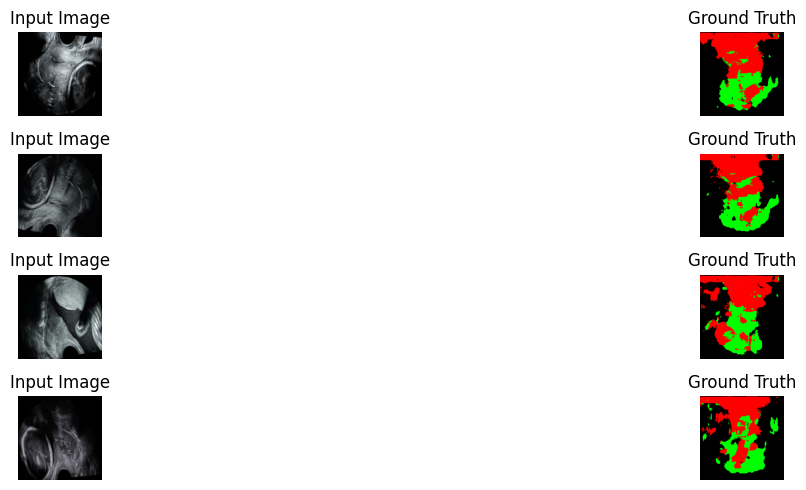

In [15]:
# Visualize unlabeled data with generated labels
visualize_predictions(
    image_dir="dataset/unlabeled_data/images",
    labels_dir="dataset/unlabeled_data/labels",
    num_samples=4
)